### This file is used to predict all ratings in user_item matrix and find top k recommendations for any user

#### Read user and item csv files

In [2]:
import pandas as pd
import gzip
from PIL import Image
from PIL import ImageOps
import urllib.request as urllib
import urllib.error as err

import io
import numpy as np

def parse(path):
    g = gzip.open(path, 'rb')
    for line in g:
        yield eval(line)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')

In [3]:
df.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"
5,A27UF1MSF3DB2,0000031887,"C-Lo ""Cynthia""","[0, 0]",I received this today and I'm not a fan of it ...,4.0,It's ok,1396224000,"03 31, 2014"
6,A16GFPNVF4Y816,0000031887,design maven,"[0, 0]",Bought this as a backup to the regular ballet ...,5.0,Great for dress-up and for ballet practice,1399075200,"05 3, 2014"
7,A2M2APVYIB2U6K,0000031887,Jamie P.,"[0, 0]",Great tutu for a great price. It isn't a &#34;...,5.0,Great value,1356220800,"12 23, 2012"
8,A1NJ71X3YPQNQ9,0000031887,JBerger,"[0, 0]","My daughter liked this, and it with her costum...",4.0,Good,1384041600,"11 10, 2013"
9,A3EERSWHAI6SO,0000031887,"Jeffrey Hollingshead ""Jillian hollingshead""","[7, 8]",For what I paid for two tutus is unbeatable an...,5.0,WOW !! ..is all I have to say!,1349568000,"10 7, 2012"


In [4]:
user_item_data = df[['reviewerID','asin','overall','reviewTime','unixReviewTime']]

In [5]:
user_item_data.size

1393385

In [6]:
user_item_data.columns = ["User_Id", "Item_Id", "Rating", "TimeStamp","TimeStamp2"]

In [7]:
user_item_data.head()

,User_Id,Item_Id,Rating,TimeStamp,TimeStamp2
0,A1KLRMWW2FWPL4,0000031887,5.0,"02 12, 2011",1297468800
1,A2G5TCU2WDFZ65,0000031887,5.0,"01 19, 2013",1358553600
2,A1RLQXYNCMWRWN,0000031887,5.0,"01 4, 2013",1357257600
3,A8U3FAMSJVHS5,0000031887,5.0,"04 27, 2014",1398556800
4,A3GEOILWLK86XM,0000031887,5.0,"03 15, 2014",1394841600


#### No. of Unique Users

In [8]:
len(user_item_data["User_Id"].unique())

39387

#### No. of Unique Items

In [9]:
len(user_item_data["Item_Id"].unique())

23033

#### Subset1:

In [10]:
top_item = user_item_data.groupby(['Item_Id'])['Rating'].count().reset_index().sort_values(['Rating'], ascending=False).head(100) 
top_item = top_item["Item_Id"].tolist()

In [11]:
subset_user_item_data = user_item_data.loc[(user_item_data["Item_Id"].isin(top_item))]
len(subset_user_item_data["Item_Id"].unique())

100

In [12]:
top_user = subset_user_item_data.groupby(['User_Id'])['Rating'].count().reset_index().sort_values(['Rating'], ascending=False).head(100)
top_user = top_user["User_Id"].tolist()

In [13]:
subset_user_item_data = subset_user_item_data.loc[(user_item_data["User_Id"].isin(top_user))]
len(subset_user_item_data["User_Id"].unique())

100

In [14]:
len(subset_user_item_data["Item_Id"].unique())

93

#### Create test set

In [15]:
import random
def create_testdataset(dataset,k):
    test_df = pd.DataFrame(columns=["User_Id","Item_Id","Rating"])
    for i in range(0,k):
        index = random.choice(dataset.index.values.tolist())
        user = dataset.loc[index,'User_Id']
        item = dataset.loc[index,'Item_Id']
        rating = dataset.loc[index,'Rating']
        df = pd.DataFrame([[user,item,rating]],columns=["User_Id","Item_Id","Rating"])
        test_df = test_df.append(df)
    return test_df

In [16]:
test_df = create_testdataset(subset_user_item_data,3)
test_df = test_df.reset_index()
del test_df['index']
test_df.head(5)

,User_Id,Item_Id,Rating
0,AHCI6ZIQY1PZQ,B00DMWQK0W,5.0
1,A173DBUQREF47M,B0083S18LQ,5.0
2,A29313797NGT9L,B0000ANHST,4.0


#### Create user_item matrix and check sparsity

In [17]:
import scipy.sparse
from scipy.sparse import csr_matrix
import sklearn

In [18]:
#Create user-item matrix from train set dataframe
subset_user_item_data = subset_user_item_data[["User_Id","Item_Id","Rating"]]
user_item_pivot = subset_user_item_data.pivot(index="User_Id",columns="Item_Id", values="Rating")
userId = user_item_pivot.index
itemId = user_item_pivot.columns

In [19]:
#Remove the ratings of rows in test set from train set
for i in range(0,test_df.shape[0]):
    user_item_pivot.loc[test_df.User_Id[i]][test_df.Item_Id[i]] = np.nan

In [20]:
#Create matrix filled with zeros and not filled with zeros
user_item_matrix = csr_matrix(user_item_pivot.values)
user_item_pivot_filled_zeros = user_item_pivot.fillna(0)
user_item_matrix_filled_zeros = csr_matrix(user_item_pivot_filled_zeros.values)

In [21]:
#Calculate sparsity of user_item matrix
missing = pd.DataFrame(np.isnan(user_item_pivot).sum()/np.prod(user_item_pivot.shape))
missing = missing.reset_index()
missing.columns = ["Item_Id", "percent_missing"]
missing.percent_missing.sum()

0.9481720430107525

### Baseline Model

#### Matrix Factorization

In [22]:
#calculate mean of ratings for each user
user_item_pivot_base = user_item_pivot.copy(deep=True)

In [23]:
#calculate mean of ratings for each user
user_item_pivot_base['Mean'] = user_item_pivot_base.mean(axis=1)
#store in another matrix and subract mean column from all other columns in user-item matrix
user_item_pivot2_base = user_item_pivot_base.copy(deep=True)
user_item_pivot2_base = user_item_pivot2_base.sub(user_item_pivot_base['Mean'].reset_index().Mean.tolist(),axis=0)
user_item_pivot2_base['Mean'] = user_item_pivot_base['Mean']
user_item_pivot2_base.head()

Item_Id,B000072UMJ,B0000ANHST,B00012O12A,B0001ZNZJM,B0002TOZ1E,B0006LMBJ6,B0007CKMA4,B0007QCOTM,B0007YR8WW,B0007YVP1W,...,B009ZDEXQK,B00BNB3A0W,B00CIBCJ62,B00CKGB85I,B00CN47GXA,B00DMWQK0W,B00DMWQOYY,B00DNQIIE8,B00DQYNS3I,Mean
User_Id,,,,,,,,,,,,,,,,,,,,,
A11TXTVCFT246T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,5.00
A122XGIAS5WN57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.25,NaN,NaN,NaN,-0.25,NaN,4.25
A13UGU4VH0JLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,5.00
A15IA85Q8LLW5Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.60,NaN,4.40
A15PNIMFUHBW83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00


In [24]:
user_item_demeaned = user_item_pivot2_base.fillna(0).iloc[:,:-1]

In [25]:
#use matrix factorization to convert user-item matrix to new latent space
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(user_item_demeaned, k = 3)
sigma = np.diag(sigma)

In [26]:
#calculate predicted ratings using reduced latent space matrices
all_user_predicted_ratings_base = np.dot(np.dot(U, sigma), Vt) + np.array(user_item_pivot_base['Mean'].reset_index().Mean.tolist()).reshape(-1,1)

In [27]:
#Create user-item matrix of predictions
user_item_predictions_model_base = pd.DataFrame(all_user_predicted_ratings_base, columns = user_item_demeaned.columns)
user_item_predictions_model_base.index = user_item_demeaned.index

In [28]:
user_item_predictions_model_base

Item_Id,B000072UMJ,B0000ANHST,B00012O12A,B0001ZNZJM,B0002TOZ1E,B0006LMBJ6,B0007CKMA4,B0007QCOTM,B0007YR8WW,B0007YVP1W,...,B009DNWFD0,B009ZDEXQK,B00BNB3A0W,B00CIBCJ62,B00CKGB85I,B00CN47GXA,B00DMWQK0W,B00DMWQOYY,B00DNQIIE8,B00DQYNS3I
User_Id,,,,,,,,,,,,,,,,,,,,,
A11TXTVCFT246T,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A122XGIAS5WN57,4.250000,4.250000,4.250000,4.250000,4.250000,4.249189,4.250000,4.250000,4.249947,4.250006,...,4.250295,4.250000,4.205146,4.252150,4.249976,4.248358,4.243761,4.267349,4.208801,4.248329
A13UGU4VH0JLR,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A15IA85Q8LLW5Q,4.400000,4.400000,4.400000,4.400000,4.400000,4.413897,4.400000,4.400000,4.400575,4.399985,...,4.399276,4.400001,4.623861,4.401589,4.400594,4.422267,4.439799,4.347638,4.802015,4.414955
A15PNIMFUHBW83,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A168W1XDQRE2IQ,4.666667,4.666667,4.666667,4.666667,4.666667,4.667400,4.666667,4.666667,4.666856,4.666619,...,4.664407,4.666667,4.827630,4.647325,4.666512,4.671618,4.648042,4.559535,4.805083,4.673934
A173DBUQREF47M,4.666667,4.666667,4.666667,4.666667,4.666667,4.666723,4.666667,4.666667,4.666669,4.666667,...,4.666666,4.666667,4.668301,4.666687,4.666670,4.666748,4.667203,4.666399,4.668446,4.666725
A183TEV2X7CBCP,4.600000,4.600000,4.600000,4.600000,4.600000,4.602391,4.600000,4.600000,4.600478,4.599888,...,4.594648,4.600001,5.041479,4.554449,4.599702,4.612408,4.580103,4.336922,4.960368,4.618030
A196B1TB4WZARE,4.000000,4.000000,4.000000,4.000000,4.000000,4.006879,4.000000,4.000000,4.000451,3.999948,...,3.997463,4.000001,4.366956,3.981496,4.000190,4.014072,4.045913,3.853811,4.346501,4.014204


#### Evaluation Metrics

In [29]:
#prints predicted and orginal ratings given test set and array of predicted ratings for user-item combinations in test set
def print_ratings(test_df,user_item_predicted):
    user_item_predicted_array = []
    for i in range(0,test_df.shape[0]):
        print("User ID:", test_df.User_Id[i])
        print("Predicted Ratings:", user_item_predicted.loc[test_df.User_Id[i]][test_df.Item_Id[i]])
        print("Original Ratings:",test_df.Rating[i])
        print("\n")
        user_item_predicted_array.append(user_item_predicted.loc[test_df.User_Id[i]][test_df.Item_Id[i]])
    
    return np.array(user_item_predicted_array)

In [30]:
#returns rmse given predicted and observed rating arrays
def calculate_rmse(predicted_rating,observed_rating):
    rmse = np.sqrt((np.sum(np.square(predicted_rating-observed_rating)))/(len(observed_rating)))
    return rmse

In [31]:
#returns mae given predicted and observed rating arrays
def calculate_mae(predicted_rating,observed_rating):
    mae = (np.sum(abs(predicted_rating-observed_rating)))/(len(observed_rating))
    return mae

In [32]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predictions_model_base)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: AHCI6ZIQY1PZQ
Predicted Ratings: 4.929603219511329
Original Ratings: 5.0


User ID: A173DBUQREF47M
Predicted Ratings: 4.666661473857468
Original Ratings: 5.0


User ID: A29313797NGT9L
Predicted Ratings: 3.8
Original Ratings: 4.0


Root Mean Square Error for Test Data: 0.22808644539154113
Mean Absolute Error for Test Data: 0.20124510221040084


#### Coverage- Print catalog coverage and item coverage

In [33]:
#returns item coverage for dataset ie. percentage of items predicted from all items.
def calculate_items_coverage(k,user_item_predicted):
    items_recommended =[]
    for i in range(0,user_item_predicted.shape[0]):
        top_k_items=[]
        target_user = user_item_predicted.index[i]
        top_k_items=top_k_items_recommended(k,target_user,user_item_predicted)
        items_recommended.extend(top_k_items)
        
    items_recommended = np.unique(np.array(items_recommended)).tolist()
    print((items_recommended))
    items_coverage = len(items_recommended)/user_item_predicted.shape[1]
    return items_coverage

In [34]:
#returns top-k recommened items for any user
def top_k_items_recommended(k,userid,user_item_predicted):
    items_target = user_item_predicted.loc[userid].reset_index()
    top_k_items = items_target.sort_values(userid, ascending=False)[:k].Item_Id.tolist()
    return top_k_items

In [35]:
#returns catalog coverage for dataset ie. percentage of user-item pairs predicted from all possible user-item pairs
def calculate_catalog_coverage(k,user_item_predicted):
    total_user_item_pairs = user_item_predicted.shape[0]*user_item_predicted.shape[1]
    #since recommending items to all the users
    total_user_items_recommended = user_item_predicted.shape[0]*k
    coverage_ratio = total_user_items_recommended/total_user_item_pairs
    return coverage_ratio

In [36]:
calculate_catalog_coverage(10,user_item_predictions_model_base)

0.10752688172043011

In [37]:
calculate_items_coverage(10,user_item_predictions_model_base)

['B000072UMJ', 'B000KEG4V0', 'B000QW6LE6', 'B002KMI7OC', 'B002RADHJC', 'B003DNR2HK', 'B003NX87U6', 'B004M6XUI2', 'B004Q7AB4I', 'B004R1II48', 'B004YM2FV2', 'B004Z1CZDK', 'B0053XF2U2', 'B00550PLV8', 'B0058XIMMM', 'B005CSNTJY', 'B005GYGD7O', 'B005LERHD8', 'B005UVM368', 'B0067GUM2W', 'B0068VM5T4', 'B006SCSOOS', 'B0074T7TY0', 'B0076R6KY0', 'B0078FXHNM', 'B007RD9DS8', 'B007WA3K4Y', 'B007WNWEFC', 'B0081IZ3UA', 'B0083S18LQ', 'B008RUOCJU', 'B008WYDP1C', 'B008X0EW44', 'B00BNB3A0W', 'B00CIBCJ62', 'B00DMWQK0W', 'B00DMWQOYY', 'B00DNQIIE8', 'B00DQYNS3I']


0.41935483870967744

### Content Based Model

#### Item-item neighbours- finds the 20 nearest neigbours for each item and predicts its rating using cosine similarity for each user

In [38]:
user_item_pivot_con0 = user_item_pivot.copy(deep=True)

#### Read csv file for vector representation of item using its image

In [39]:
feature_df0 = pd.read_csv("item_vector_image3.csv")
feature_df0 = feature_df0[["asin","img_vector"]]
feature_df0.head()

,asin,img_vector
0,0000031887,"61.04323959350586,10.855009078979492,67.806251..."
1,0123456479,"69.39546203613281,28.37046241760254,44.9137649..."
2,1608299953,"59.34332275390625,30.055545806884766,47.660144..."
3,1617160377,"59.33428192138672,30.18754005432129,47.7793426..."
4,B00001W0KA,"71.78907775878906,10.117408752441406,79.442283..."


In [40]:
feature_df0_list2=subset_user_item_data['Item_Id'].tolist()
feature_df0_list2_full = feature_df0["asin"].tolist()

In [41]:
feature_df0_list2

['B000072UMJ',
 'B0000ANHST',
 'B0000ANHST',
 'B0000ANHST',
 'B00012O12A',
 'B0001ZNZJM',
 'B0001ZNZJM',
 'B0002TOZ1E',
 'B0002TOZ1E',
 'B0002TOZ1E',
 'B0002TOZ1E',
 'B0006LMBJ6',
 'B0006LMBJ6',
 'B0007CKMA4',
 'B0007CKMA4',
 'B0007QCOTM',
 'B0007YR8WW',
 'B0007YR8WW',
 'B0007YR8WW',
 'B0007YR8WW',
 'B0007YR8WW',
 'B0007YVP1W',
 'B0007YVP1W',
 'B0007YXTOS',
 'B0007YXTOS',
 'B0007YXTOS',
 'B0007YXTOS',
 'B0007YXTOS',
 'B0008172S4',
 'B0008172S4',
 'B0008172S4',
 'B0008EOEPK',
 'B0009B3IN6',
 'B0009F0Z38',
 'B000DZUGOM',
 'B000DZUGOM',
 'B000EIJG0I',
 'B000EX15NY',
 'B000FBO0DM',
 'B000FH4JJQ',
 'B000GOVRDE',
 'B000J6ZYL0',
 'B000J6ZYL0',
 'B000KD44G8',
 'B000KEG4V0',
 'B000KGOHLM',
 'B000KKTPD8',
 'B000KKTPD8',
 'B000MXIMHI',
 'B000MXIMHI',
 'B000O32MLI',
 'B000O32MLI',
 'B000O32MLI',
 'B000O32MLI',
 'B000PH25X8',
 'B000PH25X8',
 'B000QW6LE6',
 'B000QW6LE6',
 'B000QW6LE6',
 'B000T9VK56',
 'B000XDDERK',
 'B001188FZC',
 'B001188FZC',
 'B0011D2FL2',
 'B0012M0XSE',
 'B0012M0XSE',
 'B0012M0X

#### Create a list of vector reprentations of items in the subset

In [42]:
feature_df0_list =[]
for i in range(0,len(feature_df0_list2)):
    temp = feature_df0.loc[feature_df0['asin'] == feature_df0_list2[i], 'img_vector'].tolist()[0].split(",")
    feature_df0_list.append(list(map(float,temp)))
feature_df0_list

[[80.77462005615234,
  10.317708015441895,
  0.24971893429756165,
  0.0,
  109.29777526855469,
  21.76152992248535,
  54.83538818359375,
  31.535263061523438,
  80.17420959472656,
  15.910524368286133,
  31.719894409179688,
  0.0,
  38.04975891113281,
  0.0,
  16.921518325805664,
  0.0],
 [29.041706085205078,
  6.077480792999268,
  99.30674743652344,
  0.0,
  106.80196380615234,
  68.76586151123047,
  136.99757385253906,
  53.728363037109375,
  71.51164245605469,
  0.0,
  79.95951843261719,
  0.44268062710762024,
  50.348655700683594,
  18.128141403198242,
  52.49188995361328,
  5.663377285003662],
 [29.041706085205078,
  6.077480792999268,
  99.30674743652344,
  0.0,
  106.80196380615234,
  68.76586151123047,
  136.99757385253906,
  53.728363037109375,
  71.51164245605469,
  0.0,
  79.95951843261719,
  0.44268062710762024,
  50.348655700683594,
  18.128141403198242,
  52.49188995361328,
  5.663377285003662],
 [29.041706085205078,
  6.077480792999268,
  99.30674743652344,
  0.0,
  106.

#### Create pivot table for predicted ratings

In [43]:
user_item_df = pd.DataFrame(columns=["User_Id","Item_Id","Rating"])
user_item_df['User_Id'] = subset_user_item_data['User_Id']
user_item_df['Item_Id'] = subset_user_item_data['Item_Id']
user_item_df['Rating'] = [0]*subset_user_item_data.shape[0]
user_item_predicted_con = user_item_df.pivot(index="User_Id",columns="Item_Id", values="Rating")
user_item_predicted_con2 = user_item_df.pivot(index="User_Id",columns="Item_Id", values="Rating")

#### Train nearest items model on list of item vectors of subset

In [44]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=21).fit(feature_df0_list)

#### Finds the nearest neighbours of each item rated by given user and predicts their rating based on cosine similraity to items rated by given user for all users

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
import math
for i in range(0,user_item_pivot_con0.shape[0]):
    print("User:",i)
    target_user = user_item_pivot_con0.index[i]
    items_target = user_item_pivot_con0.loc[target_user]
    items_target = items_target.reset_index()
    items_target_rated = items_target[~(items_target[target_user].isna())]
    neighbours=[]
    features_neighbours = []
    rated_labels = []
    rated = []
    rated_features=[]
    for j in items_target_rated['Item_Id']:
        feature = feature_df0.loc[feature_df0['asin'] == j, 'img_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        distances, indices = nbrs.kneighbors([feature])
        rated.append(j)
        rated_features.append(feature)
        rated_labels.append(user_item_pivot_con0.loc[target_user][j])
        for i in indices[0]:
            if feature_df0_list2[i] != j:
                if feature_df0_list2[i] not in neighbours:
                    neighbours.append(feature_df0_list2[i])
                    features_neighbours.append(feature_df0_list[i])
    for k in range(0,len(neighbours)):
        sum_rating_nn = 0.0
        similarity_nn = 0.0
        for m in range(0,len(rated)):
            sum_rating_nn = sum_rating_nn+cosine_similarity([features_neighbours[k]],[rated_features[m]])[0][0]*rated_labels[m]
            similarity_nn = similarity_nn + abs(cosine_similarity([features_neighbours[k]],[rated_features[m]])[0][0])
        predicted_rating = sum_rating_nn/similarity_nn
        user_item_pivot_con0.loc[target_user][neighbours[k]]=predicted_rating
        user_item_predicted_con.loc[target_user][neighbours[k]]=predicted_rating
        user_item_predicted_con2.loc[target_user][neighbours[k]]=predicted_rating
print(user_item_pivot_con0)

User: 0
User: 1
User: 2
User: 3
User: 4
User: 5
User: 6
User: 7
User: 8
User: 9
User: 10
User: 11
User: 12
User: 13
User: 14
User: 15
User: 16
User: 17
User: 18
User: 19
User: 20
User: 21
User: 22
User: 23
User: 24
User: 25
User: 26
User: 27
User: 28
User: 29
User: 30
User: 31
User: 32
User: 33
User: 34
User: 35
User: 36
User: 37
User: 38
User: 39
User: 40
User: 41
User: 42
User: 43
User: 44
User: 45
User: 46
User: 47
User: 48
User: 49
User: 50
User: 51
User: 52
User: 53
User: 54
User: 55
User: 56
User: 57
User: 58
User: 59
User: 60
User: 61
User: 62
User: 63
User: 64
User: 65
User: 66
User: 67
User: 68
User: 69
User: 70
User: 71
User: 72
User: 73
User: 74
User: 75
User: 76
User: 77
User: 78
User: 79
User: 80
User: 81
User: 82
User: 83
User: 84
User: 85
User: 86
User: 87
User: 88
User: 89
User: 90
User: 91
User: 92
User: 93
User: 94
User: 95
User: 96
User: 97
User: 98
User: 99
Item_Id         B000072UMJ  B0000ANHST  B00012O12A  B0001ZNZJM  B0002TOZ1E  \
User_Id                         

#### The sparsity of user-item matrix is reduced significantly

In [46]:
user_item_pivot_con0

Item_Id,B000072UMJ,B0000ANHST,B00012O12A,B0001ZNZJM,B0002TOZ1E,B0006LMBJ6,B0007CKMA4,B0007QCOTM,B0007YR8WW,B0007YVP1W,...,B009DNWFD0,B009ZDEXQK,B00BNB3A0W,B00CIBCJ62,B00CKGB85I,B00CN47GXA,B00DMWQK0W,B00DMWQOYY,B00DNQIIE8,B00DQYNS3I
User_Id,,,,,,,,,,,,,,,,,,,,,
A11TXTVCFT246T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,5.0,NaN,NaN
A122XGIAS5WN57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.245844,NaN,NaN,NaN,4.0,NaN
A13UGU4VH0JLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
A15IA85Q8LLW5Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
A15PNIMFUHBW83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A168W1XDQRE2IQ,NaN,NaN,NaN,4.661549,4.660769,NaN,4.664272,NaN,NaN,NaN,...,NaN,4.667790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
A173DBUQREF47M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.000000,4.654759,NaN,NaN,NaN
A183TEV2X7CBCP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,5.0,NaN
A196B1TB4WZARE,NaN,3.960323,NaN,NaN,NaN,NaN,NaN,3.969062,NaN,NaN,...,NaN,3.990178,NaN,NaN,3.908921,4.012973,NaN,NaN,5.0,NaN


#### Doc2Vec- This section uses the user-item matrix created by item-item neighbours model. We have about 40 training examples of items rated by every user. We use random forest regressor to predict the remaining ratings for each user by training a regression model for each user with training examples of items rated. Each number in vector representation using Doc2vec model is used a feature and the rating is the label. We have the vector representation of all images. Thus the model predicts the rating for unrated items based on its vector represenation

#### Create a copy of user-item matrix predicted by item-item neighbours model

In [47]:
user_item_pivot_con = user_item_pivot_con0.copy(deep=True)

#### Read vector representation of each item based on textual information of item

In [48]:
feature_df = pd.read_csv("item_vector2.csv")
feature_df = feature_df[["asin","words_vector"]]

In [49]:
feature_df.head()

,asin,words_vector
0,0000031887,"-0.13755247,-0.23854996,0.2599594,0.68409824,0..."
1,0123456479,"-0.18328372,-1.0237274,-0.111990996,0.7746652,..."
2,1608299953,"-0.018653307,0.0006199626,0.06554515,0.0078448..."
3,1617160377,"-0.007659583,-0.0036083309,0.02717292,-0.01544..."
4,B00001W0KA,"-0.18820827,-0.37920812,0.344533,0.61592835,0...."


#### Cross-validation and hyper parameter tuning of Random Forest Regressor model using GridSearchCV

In [50]:
i=20
target_user = user_item_pivot_con.index[i]
items_target = user_item_pivot_con.loc[target_user]
items_target = items_target.reset_index()
items_target_na = items_target[items_target[target_user].isna()]
items_target_rated = items_target[~(items_target[target_user].isna())]
features = []
labels = []
for j in items_target_rated['Item_Id']:
    feature = feature_df.loc[feature_df['asin'] == j, 'words_vector'].tolist()[0].split(",")
    feature = list(map(float, feature))
    features.append(feature)
    labels.append(user_item_pivot_con.loc[target_user][j])
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2,4,8,10],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(features,labels)
grid_search.best_params_

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  3.8min finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

#### Create Random Forest Regressor model for each user and predict unrated items

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
for i in range(0,user_item_pivot_con.shape[0]):
    print("User:",i)
    target_user = user_item_pivot_con.index[i]
    items_target = user_item_pivot_con.loc[target_user]
    items_target = items_target.reset_index()
    items_target_na = items_target[items_target[target_user].isna()]
    items_target_rated = items_target[~(items_target[target_user].isna())]
    model = RandomForestRegressor(n_estimators=100,bootstrap=True,max_depth=110,max_features=4,min_samples_leaf=3,min_samples_split=8)
    features = []
    labels = []
    for j in items_target_rated['Item_Id']:
        feature = feature_df.loc[feature_df['asin'] == j, 'words_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        features.append(feature)
        labels.append(user_item_pivot_con.loc[target_user][j])
    model.fit(features, labels)
        
        
        
    for k in items_target_na['Item_Id']:
        feature = feature_df.loc[feature_df['asin'] == k, 'words_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        predicted_labels = model.predict([feature])
        user_item_predicted_con.loc[target_user][k]=predicted_labels[0]
user_item_predicted_con
        
    

User: 0
User: 1
User: 2
User: 3
User: 4
User: 5
User: 6
User: 7
User: 8
User: 9
User: 10
User: 11
User: 12
User: 13
User: 14
User: 15
User: 16
User: 17
User: 18
User: 19
User: 20
User: 21
User: 22
User: 23
User: 24
User: 25
User: 26
User: 27
User: 28
User: 29
User: 30
User: 31
User: 32
User: 33
User: 34
User: 35
User: 36
User: 37
User: 38
User: 39
User: 40
User: 41
User: 42
User: 43
User: 44
User: 45
User: 46
User: 47
User: 48
User: 49
User: 50
User: 51
User: 52
User: 53
User: 54
User: 55
User: 56
User: 57
User: 58
User: 59
User: 60
User: 61
User: 62
User: 63
User: 64
User: 65
User: 66
User: 67
User: 68
User: 69
User: 70
User: 71
User: 72
User: 73
User: 74
User: 75
User: 76
User: 77
User: 78
User: 79
User: 80
User: 81
User: 82
User: 83
User: 84
User: 85
User: 86
User: 87
User: 88
User: 89
User: 90
User: 91
User: 92
User: 93
User: 94
User: 95
User: 96
User: 97
User: 98
User: 99


Item_Id,B000072UMJ,B0000ANHST,B00012O12A,B0001ZNZJM,B0002TOZ1E,B0006LMBJ6,B0007CKMA4,B0007QCOTM,B0007YR8WW,B0007YVP1W,...,B009DNWFD0,B009ZDEXQK,B00BNB3A0W,B00CIBCJ62,B00CKGB85I,B00CN47GXA,B00DMWQK0W,B00DMWQOYY,B00DNQIIE8,B00DQYNS3I
User_Id,,,,,,,,,,,,,,,,,,,,,
A11TXTVCFT246T,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,5.000000,5.000000
A122XGIAS5WN57,4.309779,4.309779,4.309779,4.309779,4.309779,4.309779,4.309779,4.309779,4.309779,4.309779,...,4.309779,4.309779,4.309779,4.309779,4.245844,4.309779,4.309779,4.309779,0.000000,4.309779
A13UGU4VH0JLR,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,5.000000
A15IA85Q8LLW5Q,4.417242,4.417242,4.417242,4.417242,4.417242,4.417242,4.417242,4.417242,4.417242,4.417242,...,4.417242,4.417242,4.417242,4.417242,4.417242,4.417242,4.417242,4.417242,0.000000,4.417242
A15PNIMFUHBW83,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A168W1XDQRE2IQ,4.645589,4.665628,4.680225,4.661549,4.660769,4.654680,4.664272,4.551151,4.640142,4.667612,...,4.673555,4.667790,4.573985,4.656599,4.641456,4.632556,4.713069,4.675765,4.618418,0.000000
A173DBUQREF47M,4.674655,4.640800,4.657317,4.591630,4.656107,4.648265,4.637362,4.592673,4.647129,4.642250,...,4.701530,4.637012,4.611871,4.620669,4.662399,0.000000,4.654759,4.678424,4.601103,4.637238
A183TEV2X7CBCP,4.528000,4.528000,4.528000,4.528000,4.528000,4.528000,4.528000,4.528000,4.528000,4.528000,...,4.528000,4.528000,4.528000,4.528000,4.528000,4.528000,0.000000,4.528000,0.000000,4.528000
A196B1TB4WZARE,3.977026,3.960323,4.173009,4.100893,4.089486,4.198856,4.150509,3.969062,3.910764,3.849917,...,3.762618,3.990178,3.865202,3.806579,3.908921,4.012973,4.072788,3.944013,0.000000,4.010848


#### Evaluation Metrics

In [52]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predicted_con)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: AHCI6ZIQY1PZQ
Predicted Ratings: 4.85696412086026
Original Ratings: 5.0


User ID: A173DBUQREF47M
Predicted Ratings: 4.65399656245377
Original Ratings: 5.0


User ID: A29313797NGT9L
Predicted Ratings: 3.782076434736307
Original Ratings: 4.0


Root Mean Square Error for Test Data: 0.25011218936864127
Mean Absolute Error for Test Data: 0.235654293983221


#### Coverage- Print catalog coverage and item coverage

In [53]:
calculate_catalog_coverage(10,user_item_predicted_con)

0.10752688172043011

In [54]:
calculate_items_coverage(10,user_item_predicted_con)

['B000072UMJ', 'B0000ANHST', 'B00012O12A', 'B0001ZNZJM', 'B0002TOZ1E', 'B0006LMBJ6', 'B0007CKMA4', 'B0007QCOTM', 'B0007YR8WW', 'B0007YVP1W', 'B0007YXTOS', 'B0008172S4', 'B0008EOEPK', 'B0009B3IN6', 'B0009F0Z38', 'B000DZUGOM', 'B000EIJG0I', 'B000EX15NY', 'B000FBO0DM', 'B000FH4JJQ', 'B000GOVRDE', 'B000J6ZYL0', 'B000KD44G8', 'B000KEG4V0', 'B000KGOHLM', 'B000KKTPD8', 'B000MXIMHI', 'B000O32MLI', 'B000PH25X8', 'B000QW6LE6', 'B000T9VK56', 'B000XDDERK', 'B001188FZC', 'B0011D2FL2', 'B0012M0XSE', 'B0012QM8IS', 'B0019MPRJW', 'B001AOZVSQ', 'B001HEF6W0', 'B001IB70JY', 'B0026P45QW', 'B002APTA9K', 'B002KMI7OC', 'B002PHLVJA', 'B002RADHJC', 'B003DNR2HK', 'B003DNR4XC', 'B003XDVUEQ', 'B003YBHF82', 'B004M6XUI2', 'B004Q7AB4I', 'B004R1II48', 'B004YM2FV2', 'B004Z1CZDK', 'B0051D7GF8', 'B0051U15E4', 'B0053XF2U2', 'B00550PLV8', 'B0058XIMMM', 'B005CSNTJY', 'B005GYGD7O', 'B005LERHD8', 'B005UVM368', 'B0067GUM2W', 'B0068VM5T4', 'B006SCSOOS', 'B0074T7TY0', 'B0076R6KY0', 'B0078FXHNM', 'B007NLX16O', 'B007RD9DS8', 'B007

0.989247311827957

#### Qualitative Results

In [55]:
def parse(path):
    g = gzip.open(path, 'rb')
    for line in g:
        yield eval(line)

def getDF(path):
    i = 0
    df2 = {}
    for d in parse(path):
        df2[i] = d
        i += 1
    return pd.DataFrame.from_dict(df2, orient='index')

df2 = getDF('meta_Clothing_Shoes_and_Jewelry.json.gz')
df2.head(5)

,asin,related,title,price,salesRank,imUrl,brand,categories,description
0,0000037214,"{'also_viewed': ['B00JO8II76', 'B00DGN4R1Q', '...",Purple Sequin Tiny Dancer Tutu Ballet Dance Fa...,6.99,{'Clothing': 1233557},http://ecx.images-amazon.com/images/I/31mCncNu...,Big Dreams,"[[Clothing, Shoes & Jewelry, Girls], [Clothing...",NaN
1,0000031887,"{'also_bought': ['0000031852', '0000031895', '...",Ballet Dress-Up Fairy Tutu,6.79,{'Sports &amp; Outdoors': 8547},http://ecx.images-amazon.com/images/I/314qZjYe...,Boutique Cutie,"[[Clothing, Shoes & Jewelry, Girls, Clothing, ...",This adorable basic ballerina tutu is perfect ...
2,0123456479,"{'also_bought': ['B000BMTCK6', 'B0006JCGUM', '...",SHINING IMAGE HUGE PINK LEATHER JEWELRY BOX / ...,64.98,{'Kitchen & Dining': 16987},http://ecx.images-amazon.com/images/I/413tGhqo...,NaN,"[[Clothing, Shoes & Jewelry, Novelty, Costumes...",Elegance par excellence. Hand-crafted of the f...
3,0456844570,"{'also_viewed': ['B008MTRT1O', 'B00BUG47S4', '...",RiZ Women's Beautify Crafted &frac12; Rimmed F...,NaN,{'Clothing': 1180499},http://ecx.images-amazon.com/images/I/31QZTHxv...,NaN,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",NaN
4,0456808574,"{'also_viewed': ['B00A6JD8EA', 'B00BFL4FTA', '...",Lantin White Visor Wrap Around Ski Style Aviat...,NaN,{'Clothing': 1038084},http://ecx.images-amazon.com/images/I/31UsrgT5...,NaN,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",NaN


In [56]:
import matplotlib.pyplot as plt

#### Display items bought by user

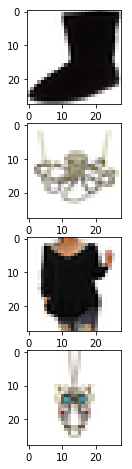

In [57]:
i=20
target_user = user_item_pivot_con.index[i]
items_target = user_item_pivot.loc[target_user]
items_target = items_target.reset_index()
items_target_rated = items_target[~(items_target[target_user].isna())]
images = []
for j in items_target_rated['Item_Id']:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Display items recommended for user

['B008RUOCJU', 'B00BNB3A0W', 'B0074T7TY0', 'B000J6ZYL0', 'B0001ZNZJM']


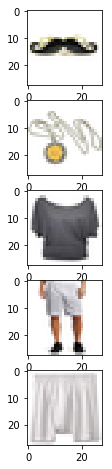

In [58]:
i=20
target_user = user_item_pivot_con.index[i]
items_target = user_item_predicted_con.loc[target_user]
items_target = items_target.reset_index()
top_k_items=top_k_items_recommended(5,target_user,user_item_predicted_con)
print(top_k_items)
images = []
for j in top_k_items:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = len(images) if len(images)<=5 else 5
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Autoencoder model-This section uses the user-item matrix created by item-item neighbours model. We have about 40 training examples of items rated by every user. We use random forest regressor to predict the remaining ratings for each user by training a regression model for each user with training examples of items rated. Each number in vector representation using Autoencoder model is used a feature and the rating is the label. We have the vector representation of all images. Thus the model predicts the rating for unrated items based on its vector represenation

#### Create a copy of user-item matrix predicted by item-item neighbours model

In [59]:
user_item_pivot_con2 = user_item_pivot_con0.copy(deep=True)

#### Read vector representation of each item based on image

In [60]:
feature_df2 = pd.read_csv("item_vector_image3.csv")
feature_df2 = feature_df2[["asin","img_vector"]]

In [61]:
feature_df2.head(5)

,asin,img_vector
0,0000031887,"61.04323959350586,10.855009078979492,67.806251..."
1,0123456479,"69.39546203613281,28.37046241760254,44.9137649..."
2,1608299953,"59.34332275390625,30.055545806884766,47.660144..."
3,1617160377,"59.33428192138672,30.18754005432129,47.7793426..."
4,B00001W0KA,"71.78907775878906,10.117408752441406,79.442283..."


#### Cross-validation and hyper parameter tuning of Random Forest Regressor model using GridSearchCV

In [62]:
i=20
target_user = user_item_pivot_con2.index[i]
items_target = user_item_pivot_con2.loc[target_user]
items_target = items_target.reset_index()
items_target_na = items_target[items_target[target_user].isna()]
items_target_rated = items_target[~(items_target[target_user].isna())]
features = []
labels = []
for j in items_target_rated['Item_Id']:
    feature = feature_df2.loc[feature_df2['asin'] == j, 'img_vector'].tolist()[0].split(",")
    feature = list(map(float, feature))
    features.append(feature)
    labels.append(user_item_pivot_con2.loc[target_user][j])
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2,4,8,10],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(features,labels)
grid_search.best_params_

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  3.8min finished


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 100}

#### Create Random Forest Regressor model for each user and predict unrated items

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
for i in range(0,user_item_pivot_con2.shape[0]):
    print("User:",i)
    target_user = user_item_pivot_con2.index[i]
    items_target = user_item_pivot_con2.loc[target_user]
    items_target = items_target.reset_index()
    items_target_na = items_target[items_target[target_user].isna()]
    items_target_rated = items_target[~(items_target[target_user].isna())]
    model = RandomForestRegressor(n_estimators=100,bootstrap=True,max_depth=110,max_features=10,min_samples_leaf=3,min_samples_split=12)
    features = []
    labels = []
    for j in items_target_rated['Item_Id']:
        feature = feature_df2.loc[feature_df2['asin'] == j, 'img_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        features.append(feature)
        labels.append(user_item_pivot_con2.loc[target_user][j])
    model.fit(features, labels)
        
        
        
    for k in items_target_na['Item_Id']:
        feature = feature_df2.loc[feature_df2['asin'] == k, 'img_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        predicted_labels = model.predict([feature])
        user_item_predicted_con2.loc[target_user][k]=predicted_labels[0]
user_item_predicted_con2

User: 0
User: 1
User: 2
User: 3
User: 4
User: 5
User: 6
User: 7
User: 8
User: 9
User: 10
User: 11
User: 12
User: 13
User: 14
User: 15
User: 16
User: 17
User: 18
User: 19
User: 20
User: 21
User: 22
User: 23
User: 24
User: 25
User: 26
User: 27
User: 28
User: 29
User: 30
User: 31
User: 32
User: 33
User: 34
User: 35
User: 36
User: 37
User: 38
User: 39
User: 40
User: 41
User: 42
User: 43
User: 44
User: 45
User: 46
User: 47
User: 48
User: 49
User: 50
User: 51
User: 52
User: 53
User: 54
User: 55
User: 56
User: 57
User: 58
User: 59
User: 60
User: 61
User: 62
User: 63
User: 64
User: 65
User: 66
User: 67
User: 68
User: 69
User: 70
User: 71
User: 72
User: 73
User: 74
User: 75
User: 76
User: 77
User: 78
User: 79
User: 80
User: 81
User: 82
User: 83
User: 84
User: 85
User: 86
User: 87
User: 88
User: 89
User: 90
User: 91
User: 92
User: 93
User: 94
User: 95
User: 96
User: 97
User: 98
User: 99


Item_Id,B000072UMJ,B0000ANHST,B00012O12A,B0001ZNZJM,B0002TOZ1E,B0006LMBJ6,B0007CKMA4,B0007QCOTM,B0007YR8WW,B0007YVP1W,...,B009DNWFD0,B009ZDEXQK,B00BNB3A0W,B00CIBCJ62,B00CKGB85I,B00CN47GXA,B00DMWQK0W,B00DMWQOYY,B00DNQIIE8,B00DQYNS3I
User_Id,,,,,,,,,,,,,,,,,,,,,
A11TXTVCFT246T,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,5.000000,5.000000
A122XGIAS5WN57,4.302732,4.302732,4.302732,4.302732,4.302732,4.302732,4.302732,4.302732,4.302732,4.302732,...,4.302732,4.302732,4.302732,4.302732,4.245844,4.302732,4.302732,4.302732,0.000000,4.302732
A13UGU4VH0JLR,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,5.000000
A15IA85Q8LLW5Q,4.436942,4.436942,4.436942,4.436942,4.436942,4.436942,4.436942,4.436942,4.436942,4.436942,...,4.436942,4.436942,4.436942,4.436942,4.436942,4.436942,4.436942,4.436942,0.000000,4.436942
A15PNIMFUHBW83,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A168W1XDQRE2IQ,4.629127,4.727939,4.722597,4.661549,4.660769,4.684744,4.664272,4.731410,4.541100,4.683255,...,4.505483,4.667790,4.569111,4.671016,4.687085,4.727414,4.616347,4.545665,4.574909,0.000000
A173DBUQREF47M,4.667908,4.667908,4.667908,4.667908,4.667908,4.667908,4.667908,4.667908,4.667908,4.667908,...,4.667908,4.667908,4.667908,4.667908,4.667908,0.000000,4.654759,4.667908,4.667908,4.667908
A183TEV2X7CBCP,4.616000,4.616000,4.616000,4.616000,4.616000,4.616000,4.616000,4.616000,4.616000,4.616000,...,4.616000,4.616000,4.616000,4.616000,4.616000,4.616000,0.000000,4.616000,0.000000,4.616000
A196B1TB4WZARE,3.984161,3.960323,3.934032,3.999684,3.967243,3.942323,3.946660,3.969062,3.941140,3.946660,...,3.904965,3.990178,4.007535,3.990388,3.908921,4.012973,3.999684,3.933569,0.000000,3.974294


#### Evaluation_metrics

In [64]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predicted_con2)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: AHCI6ZIQY1PZQ
Predicted Ratings: 4.856530593413365
Original Ratings: 5.0


User ID: A173DBUQREF47M
Predicted Ratings: 4.65399656245377
Original Ratings: 5.0


User ID: A29313797NGT9L
Predicted Ratings: 3.810333494919374
Original Ratings: 4.0


Root Mean Square Error for Test Data: 0.24240134252215426
Mean Absolute Error for Test Data: 0.22637978307116371


#### Coverage- Print catalog coverage and item coverage

In [65]:
calculate_catalog_coverage(10,user_item_predicted_con2)

0.10752688172043011

In [66]:
calculate_items_coverage(10,user_item_predicted_con2)

['B000072UMJ', 'B0000ANHST', 'B00012O12A', 'B0001ZNZJM', 'B0002TOZ1E', 'B0006LMBJ6', 'B0007CKMA4', 'B0007QCOTM', 'B0007YR8WW', 'B0007YVP1W', 'B0007YXTOS', 'B0008172S4', 'B0008EOEPK', 'B0009B3IN6', 'B0009F0Z38', 'B000DZUGOM', 'B000EIJG0I', 'B000EX15NY', 'B000FBO0DM', 'B000FH4JJQ', 'B000GOVRDE', 'B000J6ZYL0', 'B000KD44G8', 'B000KEG4V0', 'B000KGOHLM', 'B000KKTPD8', 'B000MXIMHI', 'B000O32MLI', 'B000PH25X8', 'B000QW6LE6', 'B000T9VK56', 'B000XDDERK', 'B001188FZC', 'B0011D2FL2', 'B0012M0XSE', 'B0012QM8IS', 'B0019MPRJW', 'B001AOZVSQ', 'B001HEF6W0', 'B001IB70JY', 'B0026P45QW', 'B002APTA9K', 'B002KMI7OC', 'B002PHLVJA', 'B002RADHJC', 'B003DNR2HK', 'B003DNR4XC', 'B003NX87U6', 'B003XDVUEQ', 'B003YBHF82', 'B004M6XUI2', 'B004Q7AB4I', 'B004R1II48', 'B004YM2FV2', 'B004Z1CZDK', 'B0051D7GF8', 'B0051U15E4', 'B0053XF2U2', 'B00550PLV8', 'B0058XIMMM', 'B005CSNTJY', 'B005GYGD7O', 'B005LERHD8', 'B005UVM368', 'B0067GUM2W', 'B0068VM5T4', 'B006SCSOOS', 'B0074T7TY0', 'B0076R6KY0', 'B0078FXHNM', 'B007NLX16O', 'B007

1.0

#### Qualitative Results

#### Display items bought by user

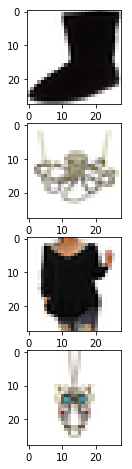

In [67]:
i=20
target_user = user_item_pivot_con2.index[i]
items_target = user_item_pivot.loc[target_user]
items_target = items_target.reset_index()
items_target_rated = items_target[~(items_target[target_user].isna())]
images = []
for j in items_target_rated['Item_Id']:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Display items recommended for user

['B003DNR4XC', 'B000FH4JJQ', 'B00DQYNS3I', 'B008KK0ZJ8', 'B007WAEBPQ']


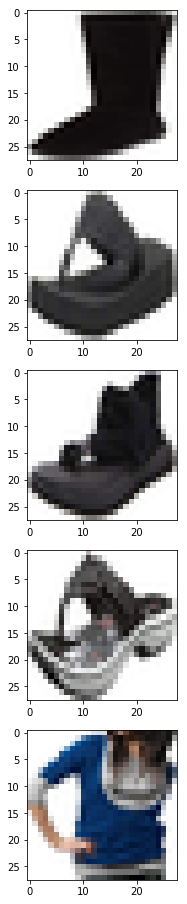

In [68]:
i=20
target_user = user_item_pivot_con2.index[i]
items_target = user_item_predicted_con2.loc[target_user]
items_target = items_target.reset_index()
top_k_items=top_k_items_recommended(5,target_user,user_item_predicted_con2)
print(top_k_items)
images = []
for j in top_k_items:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(16, 16))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Combine doc2vec based and autoencoder based content based recommendation results

In [69]:
user_item_predicted_con_hybrid = (user_item_predicted_con+user_item_predicted_con2)/2

In [70]:
user_item_predicted_con_hybrid

Item_Id,B000072UMJ,B0000ANHST,B00012O12A,B0001ZNZJM,B0002TOZ1E,B0006LMBJ6,B0007CKMA4,B0007QCOTM,B0007YR8WW,B0007YVP1W,...,B009DNWFD0,B009ZDEXQK,B00BNB3A0W,B00CIBCJ62,B00CKGB85I,B00CN47GXA,B00DMWQK0W,B00DMWQOYY,B00DNQIIE8,B00DQYNS3I
User_Id,,,,,,,,,,,,,,,,,,,,,
A11TXTVCFT246T,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,5.000000,5.000000
A122XGIAS5WN57,4.306255,4.306255,4.306255,4.306255,4.306255,4.306255,4.306255,4.306255,4.306255,4.306255,...,4.306255,4.306255,4.306255,4.306255,4.245844,4.306255,4.306255,4.306255,0.000000,4.306255
A13UGU4VH0JLR,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,5.000000
A15IA85Q8LLW5Q,4.427092,4.427092,4.427092,4.427092,4.427092,4.427092,4.427092,4.427092,4.427092,4.427092,...,4.427092,4.427092,4.427092,4.427092,4.427092,4.427092,4.427092,4.427092,0.000000,4.427092
A15PNIMFUHBW83,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A168W1XDQRE2IQ,4.637358,4.696784,4.701411,4.661549,4.660769,4.669712,4.664272,4.641281,4.590621,4.675433,...,4.589519,4.667790,4.571548,4.663807,4.664271,4.679985,4.664708,4.610715,4.596663,0.000000
A173DBUQREF47M,4.671281,4.654354,4.662612,4.629769,4.662008,4.658086,4.652635,4.630290,4.657518,4.655079,...,4.684719,4.652460,4.639889,4.644288,4.665153,0.000000,4.654759,4.673166,4.634505,4.652573
A183TEV2X7CBCP,4.572000,4.572000,4.572000,4.572000,4.572000,4.572000,4.572000,4.572000,4.572000,4.572000,...,4.572000,4.572000,4.572000,4.572000,4.572000,4.572000,0.000000,4.572000,0.000000,4.572000
A196B1TB4WZARE,3.980594,3.960323,4.053521,4.050289,4.028365,4.070589,4.048585,3.969062,3.925952,3.898289,...,3.833791,3.990178,3.936369,3.898483,3.908921,4.012973,4.036236,3.938791,0.000000,3.992571


#### Evaluation metrics

In [71]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predicted_con_hybrid)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: AHCI6ZIQY1PZQ
Predicted Ratings: 4.856747357136813
Original Ratings: 5.0


User ID: A173DBUQREF47M
Predicted Ratings: 4.65399656245377
Original Ratings: 5.0


User ID: A29313797NGT9L
Predicted Ratings: 3.79620496482784
Original Ratings: 4.0


Root Mean Square Error for Test Data: 0.24615179249257121
Mean Absolute Error for Test Data: 0.23101703852719227


#### Coverage

In [72]:
calculate_catalog_coverage(10,user_item_predicted_con_hybrid)

0.10752688172043011

In [73]:
calculate_items_coverage(10,user_item_predicted_con_hybrid)

['B000072UMJ', 'B0000ANHST', 'B00012O12A', 'B0001ZNZJM', 'B0002TOZ1E', 'B0006LMBJ6', 'B0007CKMA4', 'B0007QCOTM', 'B0007YR8WW', 'B0007YVP1W', 'B0007YXTOS', 'B0008172S4', 'B0008EOEPK', 'B0009B3IN6', 'B0009F0Z38', 'B000DZUGOM', 'B000EIJG0I', 'B000EX15NY', 'B000FBO0DM', 'B000FH4JJQ', 'B000GOVRDE', 'B000J6ZYL0', 'B000KD44G8', 'B000KEG4V0', 'B000KGOHLM', 'B000KKTPD8', 'B000MXIMHI', 'B000O32MLI', 'B000PH25X8', 'B000QW6LE6', 'B000T9VK56', 'B000XDDERK', 'B001188FZC', 'B0011D2FL2', 'B0012M0XSE', 'B0012QM8IS', 'B0019MPRJW', 'B001AOZVSQ', 'B001HEF6W0', 'B001IB70JY', 'B0026P45QW', 'B002APTA9K', 'B002KMI7OC', 'B002PHLVJA', 'B002RADHJC', 'B003DNR2HK', 'B003DNR4XC', 'B003NX87U6', 'B003XDVUEQ', 'B003YBHF82', 'B004M6XUI2', 'B004Q7AB4I', 'B004R1II48', 'B004YM2FV2', 'B004Z1CZDK', 'B0051D7GF8', 'B0051U15E4', 'B0053XF2U2', 'B00550PLV8', 'B0058XIMMM', 'B005CSNTJY', 'B005GYGD7O', 'B005LERHD8', 'B005UVM368', 'B0067GUM2W', 'B0068VM5T4', 'B006SCSOOS', 'B0074T7TY0', 'B0076R6KY0', 'B0078FXHNM', 'B007NLX16O', 'B007

1.0

#### Qualitative Results

#### Display items bought by user

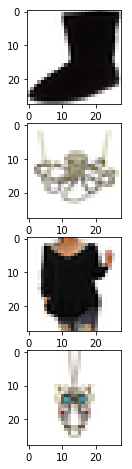

In [74]:
i=20
target_user = user_item_pivot_con.index[i]
items_target = user_item_pivot.loc[target_user]
items_target = items_target.reset_index()
items_target_rated = items_target[~(items_target[target_user].isna())]
images = []
for j in items_target_rated['Item_Id']:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Display items recommended for user

['B008RUOCJU', 'B00BNB3A0W', 'B0001ZNZJM', 'B003DNR4XC', 'B009ZDEXQK']


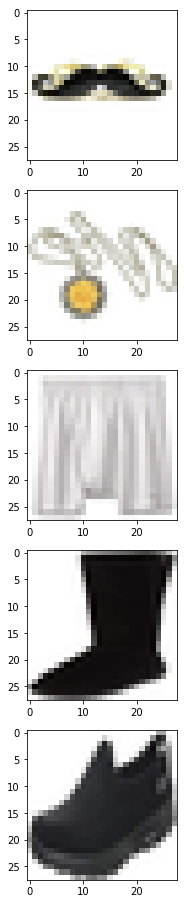

In [75]:
i=20
target_user = user_item_pivot_con.index[i]
items_target = user_item_predicted_con_hybrid.loc[target_user]
items_target = items_target.reset_index()
top_k_items=top_k_items_recommended(5,target_user,user_item_predicted_con_hybrid)
print(top_k_items)
images = []
for j in top_k_items:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(16, 16))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()